# Chapter 14: Going Deeper -- the Mechanics of TensorFlow (Part 1/3)

### Creating a graph in TensorFlow v1.x

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# TF-v1.x style
g = tf.Graph()
with g.as_default():
    a = tf.constant(1, name='a')
    b = tf.constant(2, name='b')
    c = tf.constant(3, name='c')
    z = 2 * (a - b) + c

with tf.compat.v1.Session(graph=g) as sess:
    print("Result: z =", sess.run(z))
    print('Result: z =', z.eval())

Result: z = 1
Result: z = 1


### Migrating a graph to TensorFlow v2

In [4]:
## TF v2 style
a = tf.constant(1, name='a')
b = tf.constant(2, name='b')
c = tf.constant(3, name='c')

z = 2*(a - b) + c
tf.print('Result: z =', z)

Result: z = 1


### Loading input data into a model: TensorFlow v1.x style

In [5]:
# TF-v1.x style
g = tf.Graph()
with g.as_default():
    a = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_a')
    b = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_b')
    c = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_c')
    z = 2*(a - b) + c

with tf.compat.v1.Session(graph=g) as sess:
    feed_dict = {a:1, b:2, c:3}
    print('Result: z =', sess.run(z, feed_dict=feed_dict))

Result: z = 1


### Loading input data into a model: TensorFlow v2 style

In [6]:
## TF-v2 style
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

tf.print('Scalar Inputs:', compute_z(1, 2, 3))
tf.print('Rank 1 Inputs:', compute_z([1], [2], [3]))
tf.print('Rank 2 Inputs:', compute_z([[1]], [[2]], [[3]]))

Scalar Inputs: 1
Rank 1 Inputs: [1]
Rank 2 Inputs: [[1]]


### Improving computational performance with function decorators

In [7]:
@tf.function
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

tf.print('Scalar Inputs:', compute_z(1, 2, 3))
tf.print('Rank 1 Inputs:', compute_z([1], [2], [3]))
tf.print('Rank 2 Inputs:', compute_z([[1]], [[2]], [[3]]))

Scalar Inputs: 1
Rank 1 Inputs: [1]
Rank 2 Inputs: [[1]]


In [8]:
@tf.function(input_signature=(tf.TensorSpec(shape=[None], dtype=tf.int32),
                              tf.TensorSpec(shape=[None], dtype=tf.int32),
                              tf.TensorSpec(shape=[None], dtype=tf.int32),))
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

tf.print('Rank 1 Inputs:', compute_z([1], [2], [3]))
tf.print('Rank 1 Inputs:', compute_z([1, 2], [2, 4], [3, 6]))

Rank 1 Inputs: [1]
Rank 1 Inputs: [1 2]


## TensorFlow Variable objects for storing and updating model parameters

In [9]:
a = tf.Variable(initial_value=3.14, name='var_a')
b = tf.Variable(initial_value=[1, 2, 3], name='var_b')
c = tf.Variable(initial_value=[True, False], dtype=tf.bool)
d = tf.Variable(initial_value=['abc'], dtype=tf.string)
print(a)
print(b)
print(c)
print(d)

<tf.Variable 'var_a:0' shape=() dtype=float32, numpy=3.14>
<tf.Variable 'var_b:0' shape=(3,) dtype=int32, numpy=array([1, 2, 3], dtype=int32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=bool, numpy=array([ True, False])>
<tf.Variable 'Variable:0' shape=(1,) dtype=string, numpy=array([b'abc'], dtype=object)>


In [10]:
a.trainable

True

In [11]:
w = tf.Variable([1, 2, 3], trainable=False)
print(w.trainable)

False


In [12]:
print(w.assign([3, 1, 4], read_value=True))
w.assign_add([2, -1, 2], read_value=False)

print(w.value())

<tf.Variable 'UnreadVariable' shape=(3,) dtype=int32, numpy=array([3, 1, 4], dtype=int32)>
tf.Tensor([5 0 6], shape=(3,), dtype=int32)


In [13]:
tf.random.set_seed(1)
init = tf.keras.initializers.GlorotNormal()

tf.print(init(shape=(3,)))

[0.360552639 0.415969521 -0.263839304]


In [14]:
v = tf.Variable(init(shape=(2, 3)))
tf.print(v)

[[0.394965619 0.455671787 -0.289021492]
 [0.460573 -0.0934807658 -1.12315166]]


/Users/wangrui/opt/anaconda3/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [15]:
class MyModule(tf.Module):
    def __init__(self):
        init = tf.keras.initializers.GlorotNormal()
        self.w1 = tf.Variable(init(shape=(2, 3)), trainable=True)
        self.w2 = tf.Variable(init(shape=(1, 2)), trainable=False)

m = MyModule()
print('All module variables: ', [v.shape for v in m.variables])
print('Trainable variable:   ', [v.shape for v in
                                 m.trainable_variables])

All module variables:  [TensorShape([2, 3]), TensorShape([1, 2])]
Trainable variable:    [TensorShape([2, 3])]


In [16]:
# ariables with tf.function
tf.random.set_seed(1)
w = tf.Variable(tf.random.uniform((3, 3)))

@tf.function
def compute_z(x):
    return tf.matmul(w, x)

x = tf.constant([[1], [2], [3]], dtype=tf.float32)
tf.print(compute_z(x))

[[3.8610158]
 [2.94593048]
 [3.82629013]]


## Computing gradients via automatic differentiation and GradientTape

In [17]:
### Computing the gradients of the loss with respect to trainable variables

w = tf.Variable(1.0)
b = tf.Variable(0.5)
print(w.trainable, b.trainable)

x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])

with tf.GradientTape() as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)

tf.print('dL/dw : ', dloss_dw)

True True
dL/dw :  -0.559999764


In [18]:
# verifying the computed gradient
#tf.print(-2*x * (-b - w*x + y))

tf.print(2*x * ((w*x + b) - y))

[-0.559999764]


In [19]:
### Computing gradients with respect to non-trainable tensors
# Monitoring the non-trainable tensors via `tape.watch()`

with tf.GradientTape() as tape:
    tape.watch(x)
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.square(y - z)

dloss_dx = tape.gradient(loss, x)

tf.print('dL/dx:', dloss_dx)

dL/dx: [-0.399999857]


In [20]:
# verifying the computed gradient
tf.print(2*w * ((w*x + b) - y))

[-0.399999857]


### Keeping resources for multiple gradient computations

via `persistent=True`

In [21]:
with tf.GradientTape(persistent=True) as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)
dloss_db = tape.gradient(loss, b)

tf.print('dL/dw:', dloss_dw)
tf.print('dL/db:', dloss_db)

dL/dw: -0.559999764
dL/db: -0.399999857


#### Updating variables: `optimizer.apply_gradients()`

In [22]:
optimizer = tf.keras.optimizers.SGD()

optimizer.apply_gradients(zip([dloss_dw, dloss_db], [w, b]))

tf.print('Updated w:', w)
tf.print('Updated bias:', b)

Updated w: 1.0056
Updated bias: 0.504


## Simplifying implementations of common architectures via the Keras API

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

# late variable creation
model.build(input_shape=(None, 4))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
Total params: 624 (2.44 KB)
Trainable params: 624 (2.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
## printing variable of the model
for v in model.variables:
    print('{:20s}'.format(v.name), v.trainable, v.shape)

dense/kernel:0       True (4, 16)
dense/bias:0         True (16,)
dense_1/kernel:0     True (16, 32)
dense_1/bias:0       True (32,)


### Compile a model

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()]
)

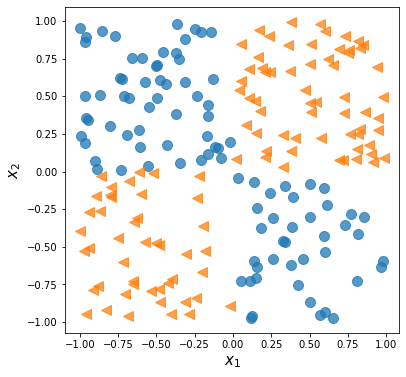

In [27]:
# XOR问题

tf.random.set_seed(1)
np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

x_train = x[:100, :]
y_train = y[:100]
x_valid = x[100:, :]
y_valid = y[100:]

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0],
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0],
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

In [28]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1,
                                input_shape=(2, ),
                                activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

    1/10368 [..............................] - ETA: 15:58

<ipython-input-30-244ea04dbace>:19: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


10368/10368 [==============================] - 20s 2ms/step


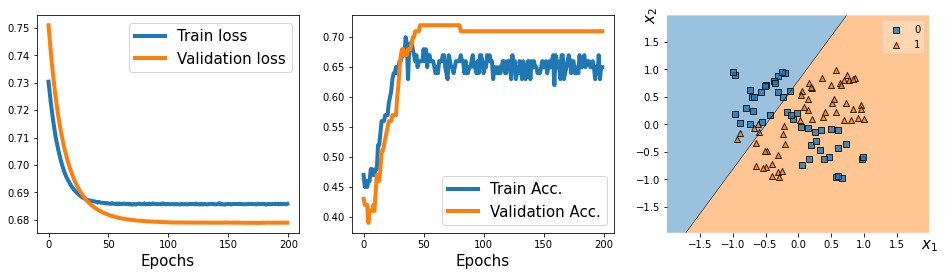

In [30]:
from mlxtend.plotting import plot_decision_regions

history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

In [31]:
tf.random.set_seed(1)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=(2,), activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.summary()

## compile:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## train:
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

history = hist.history

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4)                 12        
                                                                 
 dense_4 (Dense)             (None, 4)                 20        
                                                                 
 dense_5 (Dense)             (None, 4)                 20        
                                                                 
 dense_6 (Dense)             (None, 1)                 5         
                                                                 
Total params: 57 (228.00 Byte)
Trainable params: 57 (228.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


  111/10368 [..............................] - ETA: 9s

<ipython-input-32-a6e45b685f67>:15: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


10368/10368 [==============================] - 13s 1ms/step


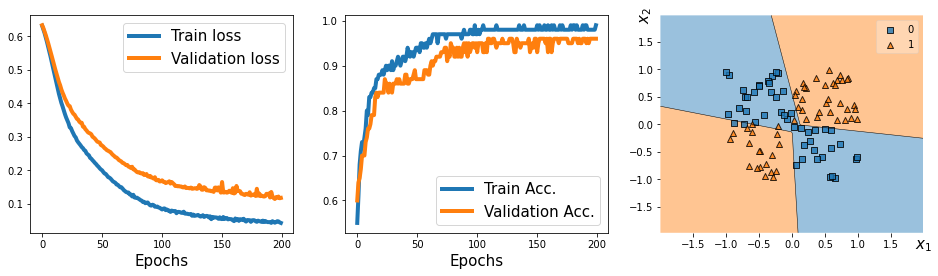

In [32]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

## Making model building more flexible with Keras' functional API

In [33]:
tf.random.set_seed(1)

## input layer:
inputs = tf.keras.Input(shape=(2,))

## hidden layers
h1 = tf.keras.layers.Dense(units=4, activation='relu')(inputs)
h2 = tf.keras.layers.Dense(units=4, activation='relu')(h1)
h3 = tf.keras.layers.Dense(units=4, activation='relu')(h2)

## output:
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(h3)

## construct a model:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 12        
                                                                 
 dense_8 (Dense)             (None, 4)                 20        
                                                                 
 dense_9 (Dense)             (None, 4)                 20        
                                                                 
 dense_10 (Dense)            (None, 1)                 5         
                                                                 
Total params: 57 (228.00 Byte)
Trainable params: 57 (228.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


  178/10368 [..............................] - ETA: 5s

<ipython-input-34-c060f6bf5542>:28: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


10368/10368 [==============================] - 6s 554us/step


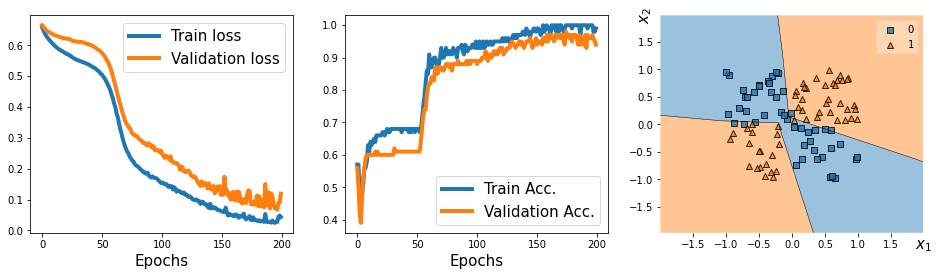

In [34]:
## compile:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## train:
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

## Plotting
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

## Writing custom Keras layers


#### Defining a custom layer:
 * Define `__init__()`
 * Define `build()` for late-variable creation
 * Define `call()`
 * Define `get_config()` for serialization

In [35]:
class NoisyLinear(tf.keras.layers.Layer):
    def __init__(self, output_dim, noise_stddev=0.1, **kwargs):
        self.output_dim = output_dim
        self.noise_stddev = noise_stddev
        super(NoisyLinear, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w = self.add_weight(name='weights',
                                 shape=(input_shape[1], self.output_dim),
                                 initializer='random_normal',
                                 trainable=True)

        self.b = self.add_weight(shape=(self.output_dim,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs, training=False):
        if training:
            batch = tf.shape(inputs)[0]
            dim = tf.shape(inputs)[1]
            noise = tf.random.normal(shape=(batch, dim),
                                     mean=0.0,
                                     stddev=self.noise_stddev)

            noisy_inputs = tf.add(inputs, noise)
        else:
            noisy_inputs = inputs
        z = tf.matmul(noisy_inputs, self.w) + self.b
        return tf.keras.activations.relu(z)

    def get_config(self):
        config = super(NoisyLinear, self).get_config()
        config.update({'output_dim': self.output_dim,
                       'noise_stddev': self.noise_stddev})
        return config


## testing:

tf.random.set_seed(1)

noisy_layer = NoisyLinear(4)
noisy_layer.build(input_shape=(None, 4))

x = tf.zeros(shape=(1, 4))
tf.print(noisy_layer(x, training=True))

## re-building from config:
config = noisy_layer.get_config()
new_layer = NoisyLinear.from_config(config)
tf.print(new_layer(x, training=True))

[[0.0141729293 0.0221370272 0 0.0116078258]]
[[0 0.0023538731 0 0.00543170422]]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noisy_linear_1 (NoisyLinea  (None, 4)                 12        
 r)                                                              
                                                                 
 dense_11 (Dense)            (None, 4)                 20        
                                                                 
 dense_12 (Dense)            (None, 4)                 20        
                                                                 
 dense_13 (Dense)            (None, 1)                 5         
                                                                 
Total params: 57 (228.00 Byte)
Trainable params: 57 (228.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
  188/10368 [..............................] - ETA: 5s

<ipython-input-36-c498275e79e3>:40: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


10368/10368 [==============================] - 6s 572us/step


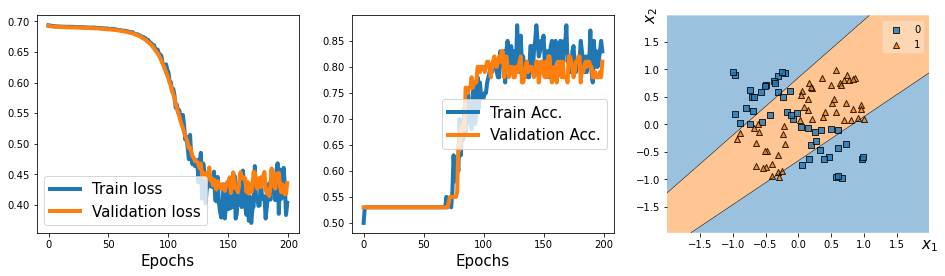

In [36]:
tf.random.set_seed(1)

model = tf.keras.Sequential([
    NoisyLinear(4, noise_stddev=0.1),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])

model.build(input_shape=(None, 2))
model.summary()

## compile:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## train:
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2,
                 verbose=0)

## Plotting
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()